# Differentiating notebooks and books

The project's proposal is to differentiate between notebooks and books, which despite their similarity, one has content and the other does not. After training a model, deploy it on Hugging Face for testing

## Downloading the requirements

In [2]:
# Kaggle requires phone verification to use the internet or a GPU. If you haven't done that yet, the cell below will fail
#    This code is only here to check that your internet is enabled. It doesn't do anything else.

import socket,warnings
try:
    socket.setdefaulttimeout(1)
    socket.socket(socket.AF_INET, socket.SOCK_STREAM).connect(('1.1.1.1', 53))
except socket.error as ex: raise Exception("STOP: No internet. Click '>|' in top right and set 'Internet' switch to on")
    
# Make sure we've got the latest version of fastai:
!pip install -Uqq fastai duckduckgo_search

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dask-cudf 21.10.1 requires cupy-cuda114, which is not installed.
beatrix-jupyterlab 3.1.7 requires google-cloud-bigquery-storage, which is not installed.
google-cloud-aiplatform 0.6.0a1 requires google-cloud-storage<2.0.0dev,>=1.26.0, but you have google-cloud-storage 2.1.0 which is incompatible.
gcsfs 2022.2.0 requires fsspec==2022.02.0, but you have fsspec 2022.3.0 which is incompatible.
en-core-web-sm 3.2.0 requires spacy<3.3.0,>=3.2.0, but you have spacy 3.5.2 which is incompatible.
en-core-web-lg 3.2.0 requires spacy<3.3.0,>=3.2.0, but you have spacy 3.5.2 which is incompatible.
dask-cudf 21.10.1 requires dask==2021.09.1, but you have dask 2022.2.0 which is incompatible.
dask-cudf 21.10.1 requires distributed==2021.09.1, but you have distributed 2022.2.0 which is incompatible.
apache-beam 2.37.0 requires dill

## Importing the libraries

In [3]:
from fastai.vision.all import *
from duckduckgo_search import ddg_images
from fastdownload import download_url

## Defining the search string and the function that does the search in duckduckgo

In [4]:
# Declaring the texts that are going to be used to find images from DuckDuckGo
search_string = 'book','paper notebook'

# The function uses the ddg_images function from the duckduckgo_search package to search for images related to the term.
#  It passes the term and max_results parameters to the ddg_images function to retrieve the image URLs.
#  The function returns the list of image URLs and also prints a message indicating the search term that was used.
def search_images(term, max_images=80):
    print(f"Searching for '{term}'\n\n")
    return L(ddg_images(term, max_results=max_images)).itemgot('image')

### Example of a book photo

Searching for 'book photos'




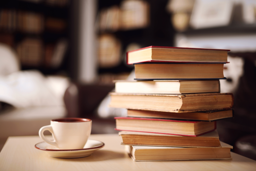

In [5]:
urls = search_images(search_string[0] + ' photos', max_images=1)

# book
dest = search_string[0] + '.jpg'
download_url(urls[0], dest, show_progress=False)

Image.open(dest).to_thumb(256,256)

### Example of a notebook photo

Searching for 'paper notebook photos'




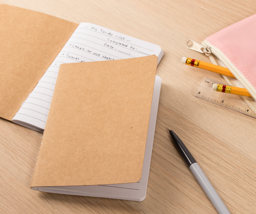

In [6]:
urls = search_images(search_string[1] + ' photos', max_images=1)

# person wearing facemask
dest = search_string[1] + '.jpg'
download_url(urls[0], dest, show_progress=False)
Image.open(dest).to_thumb(256,256)

## Download images to be used on the training and validation of the model, separated by the folder name

In [7]:
path = Path('book_or_notebook')

for label in search_string:
    dest = (path/label)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{label} photo', 100))
    resize_images(path/label, max_size=400, dest=path/label)

print('OK!\n')

Searching for 'book photo'


Searching for 'paper notebook photo'


OK!



### Removing corrupted images (failed images)

In [8]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

8

## Create the DataBlock with the images downloaded and organizing it to feed them to the learner

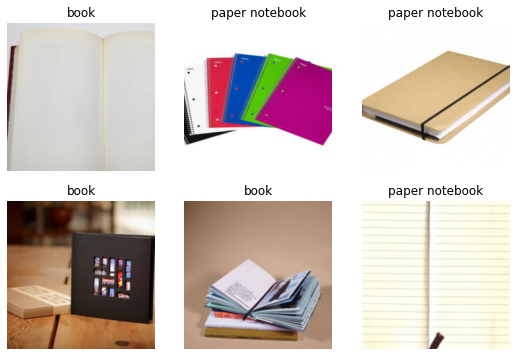

In [9]:
book_or_notebook = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=37),
    get_y=parent_label,
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
).dataloaders(path, bs=32)

book_or_notebook.show_batch(max_n=6)

## Training the pre-trained model with our data

In [10]:
learn = vision_learner(book_or_notebook, resnet18, metrics=error_rate)
learn.fine_tune(4)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,1.031056,2.089787,0.361111,00:08


epoch,train_loss,valid_loss,error_rate,time
0,0.624954,0.417423,0.111111,00:01
1,0.430087,0.036253,0.027778,00:01
2,0.295777,0.018909,0.000000,00:01
3,0.227772,0.019071,0.000000,00:01


## Export our project to be used on Hugging Face

In [65]:
learn.export('model.pkl')

## Testing

Searching for 'livro'




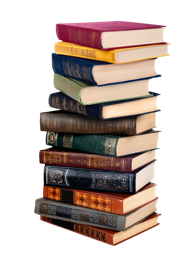

In [16]:
urls = search_images('livro', max_images=1)

# livro
book = 'livro.jpg'
download_url(urls[0], book, show_progress=False)

from fastai.vision.all import *
Image.open(book).to_thumb(256,256)

In [21]:
book_or_notebook,_,probs = learn.predict(PILImage.create(book))
print(f"This is {book_or_notebook}.")
print(f"Probability it's a book: {probs[0]:.4f}")

This is book.
Probability it's a book: 0.9999


Searching for 'caderno'




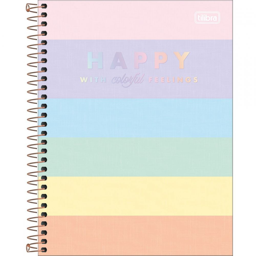

In [19]:
urls = search_images('caderno', max_images=1)

# livro
notebook = 'caderno.jpg'
download_url(urls[0], notebook, show_progress=False)

from fastai.vision.all import *
Image.open(notebook).to_thumb(256,256)

In [22]:
book_or_notebook,_,probs = learn.predict(PILImage.create(notebook))
print(f"This is {book_or_notebook}.")
print(f"Probability it's a notebook: {1 - probs[0]:.4f}")

This is paper notebook.
Probability it's a notebook: 0.9996


## Deploy

Acesse o link abaixo para testar o modelo no Hugging Face

In [ ]:
https://huggingface.co/spaces/luisgaboardi/NotebookOrBook